In [1]:
import logging
from datetime import datetime
from tqdm.auto import tqdm

from importlib import reload

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = lambda msg: print(f"{datetime.today()} {msg}")

import pandas as pd
import os

import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)


In [2]:
import paramiko

hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')
remote_dir = '/home/graham/audio'

# Create an SSH client
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname, username=username, password=password, compress=True)

stdin, stdout, stderr = ssh.exec_command(f'ls {remote_dir}')
remote_files = [f for f in stdout.read().decode().splitlines() if f.endswith(".opus")]

sftp = ssh.open_sftp()

2025-05-03 09:20:52,337 - INFO - Connected (version 2.0, client OpenSSH_9.6)
2025-05-03 09:20:52,501 - INFO - Authentication (password) successful!
2025-05-03 09:20:56,232 - INFO - [chan 1] Opened sftp connection (server version 3)


In [3]:
from notebooks.Util.DayAndNightOfFinder import day_and_night_of

interesting = [f for f in remote_files if day_and_night_of(f.removeprefix('recording_').removesuffix('.opus')) == '2025-05-02']

In [4]:
interesting2 = [f for f in interesting if f.removesuffix('.opus').split('_')[2].startswith('215')]
interesting2

['recording_20250502_215019.opus',
 'recording_20250502_215049.opus',
 'recording_20250502_215119.opus',
 'recording_20250502_215149.opus',
 'recording_20250502_215219.opus',
 'recording_20250502_215249.opus',
 'recording_20250502_215319.opus',
 'recording_20250502_215349.opus',
 'recording_20250502_215419.opus',
 'recording_20250502_215449.opus',
 'recording_20250502_215519.opus',
 'recording_20250502_215549.opus',
 'recording_20250502_215619.opus',
 'recording_20250502_215649.opus',
 'recording_20250502_215719.opus',
 'recording_20250502_215749.opus',
 'recording_20250502_215819.opus',
 'recording_20250502_215850.opus',
 'recording_20250502_215920.opus',
 'recording_20250502_215950.opus']

In [6]:
!pip install simpleaudio

  Using cached simpleaudio-1.0.4.tar.gz (2.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp313-cp313-win_amd64.whl size=2039342 sha256=5e674cd5cb987574519402cdb6869c6c49dc3bf082d5c09f376526ad5b895944
  Stored in directory: c:\users\graha\appdata\local\pip\cache\wheels\32\52\44\2d31774644c6aedd866574b86a30f6576c6dddc31fa8fb84b3
Successfully built simpleaudio


recording_20250502_215649.opus: 100%|##########| 463k/463k [00:00<00:00, 2.03MB/s]


Temp filename:  C:\Users\graha\AppData\Local\Temp\tmpdqcm9rh7.opus


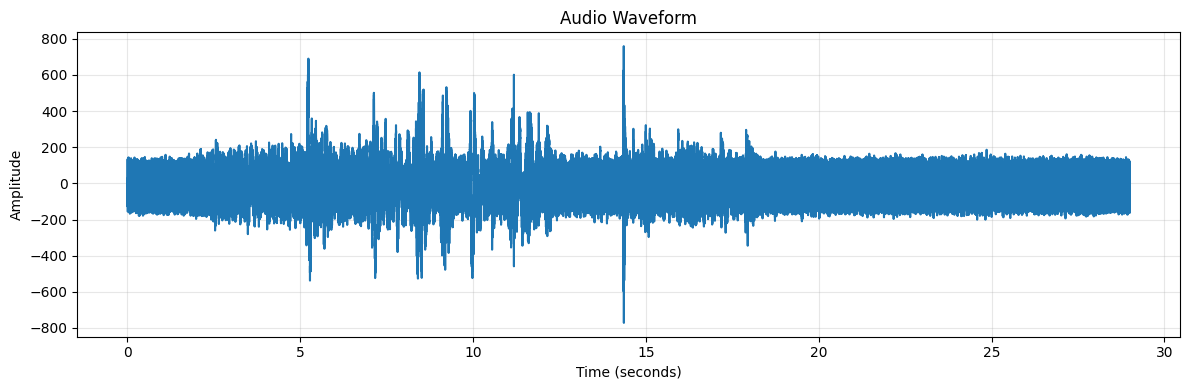

No events found


In [29]:

import audio
reload(audio)

remote_dir = '/home/graham/audio'
# filename = "recording_20250405_124536.opus"
filename = "recording_20250502_215649.opus"
data_array, ogg = audio.get_audio(sftp, remote_dir, filename)

bp = audio.best_silence_detection_params

sample_rate = ogg.frequency
events = audio.find_audio_events(data_array, sample_rate, filename,
                         window_size=bp['window_size'],
                         threshold_multiplier=bp['threshold_multiplier'],
                         min_event_duration=bp['min_event_duration'],
                         merge_distance=bp['merge_distance'])

display(audio.play_audio_widget(data_array, ogg))

if len(events) > 0:
    # Plot events
    audio.plot_audio_events(data_array, events)
else:
    print("No events found")



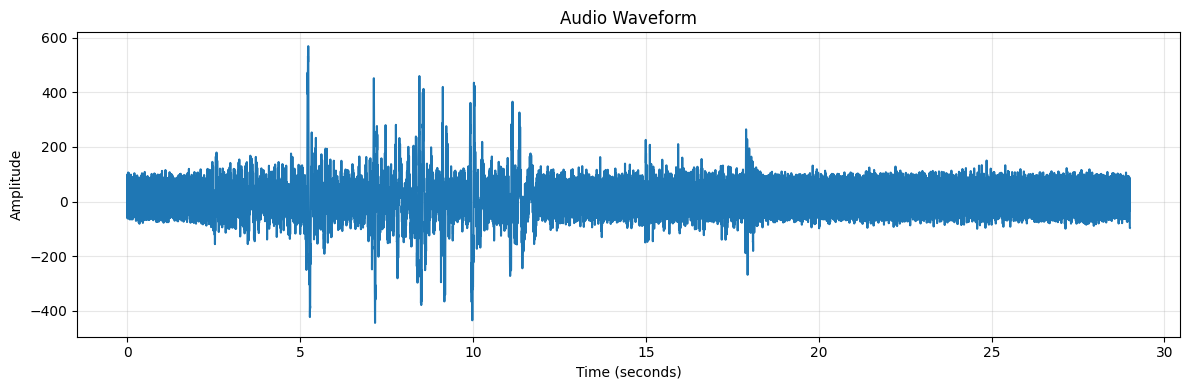

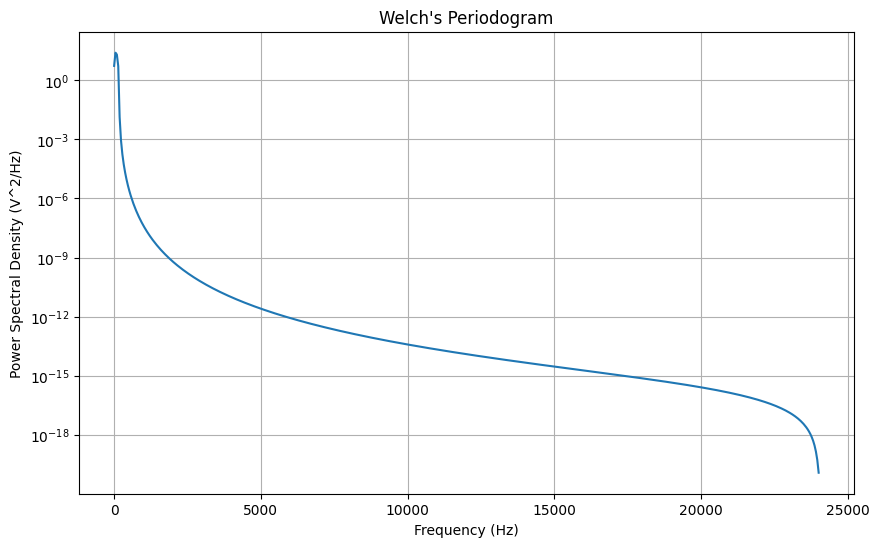

In [33]:
import audio
reload(audio)
filtered_data = audio.filter_audio(data_array, sample_rate)
audio.display_waveform(filtered_data, sample_rate)
audio.plot_power_spectrum(filtered_data, sample_rate)
display(audio.play_audio_widget(data_array, ogg))

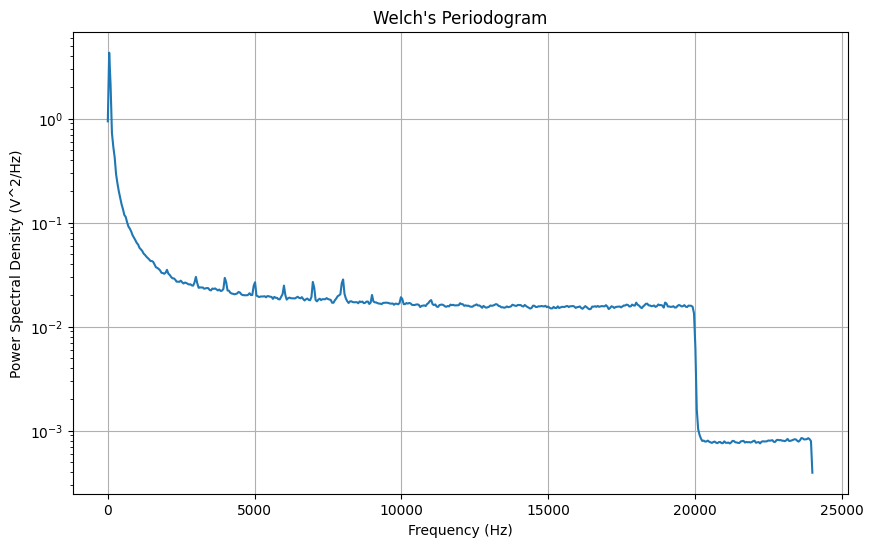

In [26]:

import audio
reload(audio)
audio.plot_power_spectrum(data_array, sample_rate)

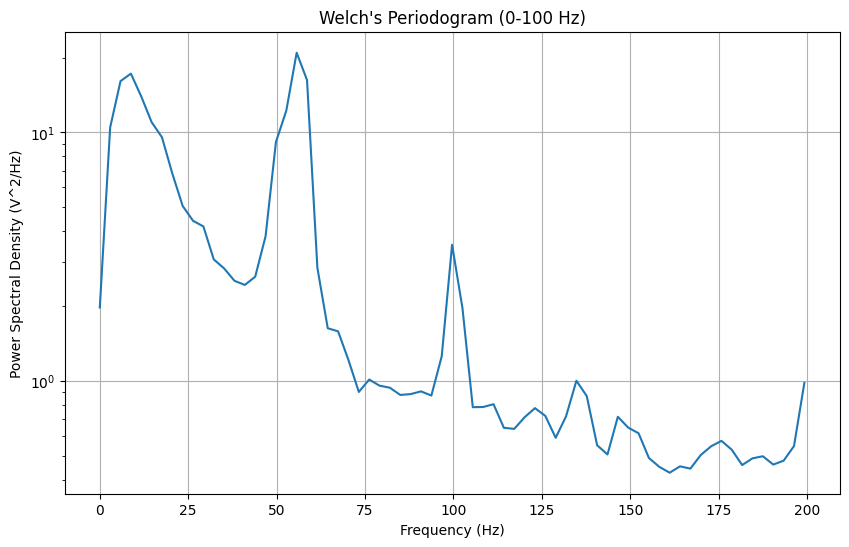

In [25]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Flatten the data_array to 1D
data_array_flat = np.ravel(data_array)

# Compute Welch's periodogram
frequencies, power_spectrum = signal.welch(data_array_flat, fs=sample_rate, nperseg=16384)

# Filter for frequencies <= 100 Hz
mask = frequencies <= 200
frequencies_filtered = frequencies[mask]
power_spectrum_filtered = power_spectrum[mask]

# Plot the periodogram for the first 100 Hz
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies_filtered, power_spectrum_filtered)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.title('Welch\'s Periodogram (0-100 Hz)')
plt.grid()
plt.show()

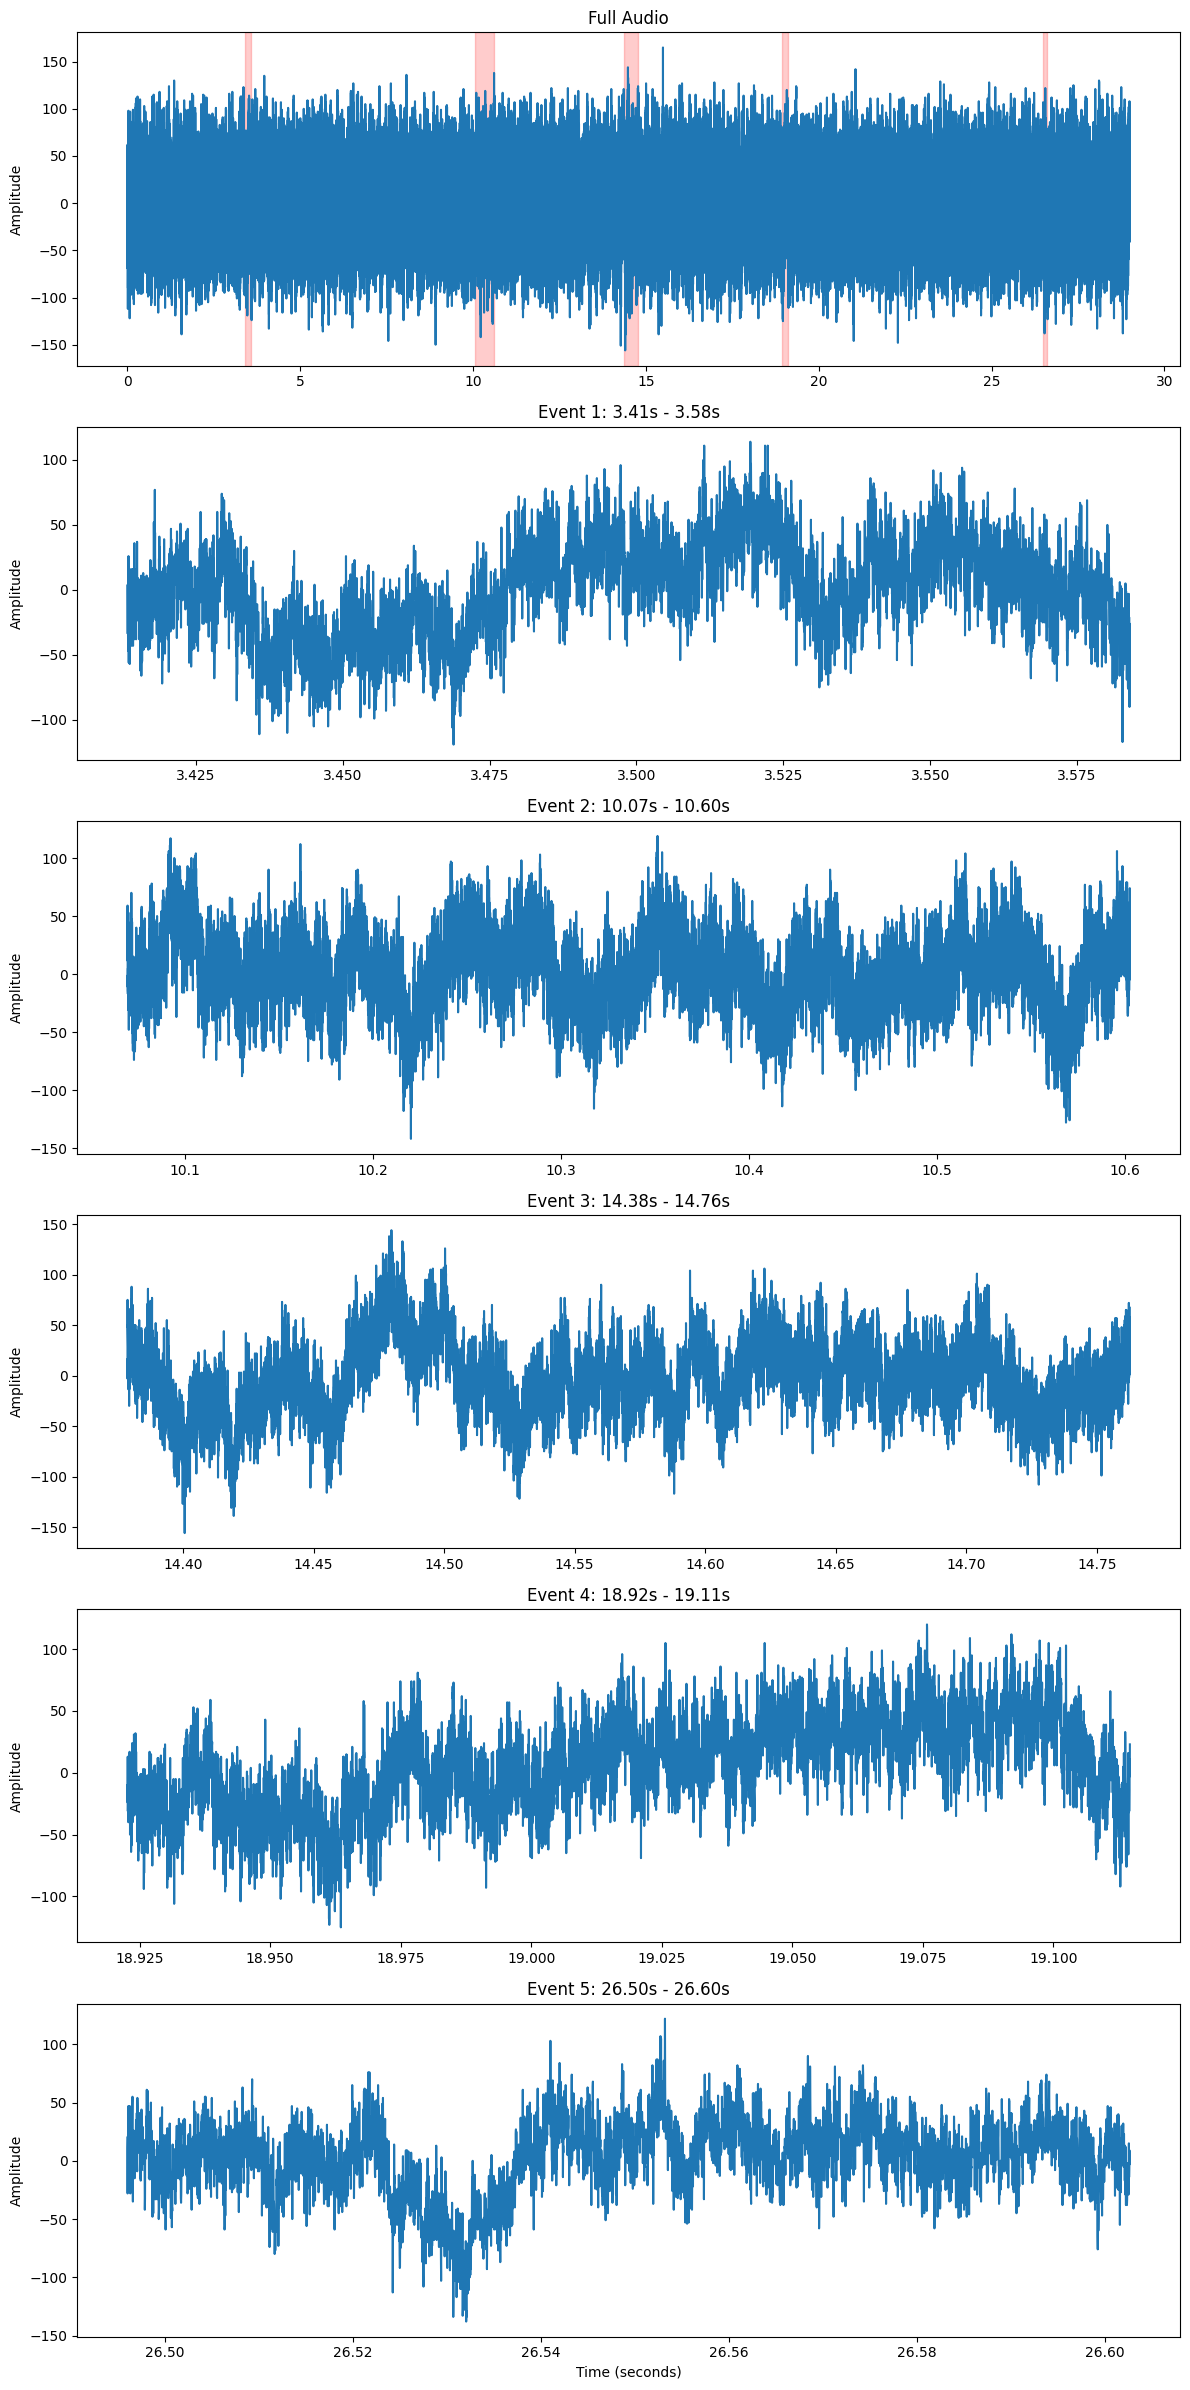

In [9]:
reload(audio)

sample_rate = ogg.frequency
events = audio.find_audio_events(data_array, sample_rate, filename,
                         window_size=1024,
                         threshold_multiplier=1.5,
                         min_event_duration=0.1,
                         merge_distance=0.5)

len(events)

# Plot events
audio.plot_audio_events(data_array, events)

# Play individual events if desired
# for i, (_, _, audio_segment) in enumerate(events, 1):
#     print(f"Event {i}:")
#     display(Audio(data=audio_segment, rate=sample_rate))    